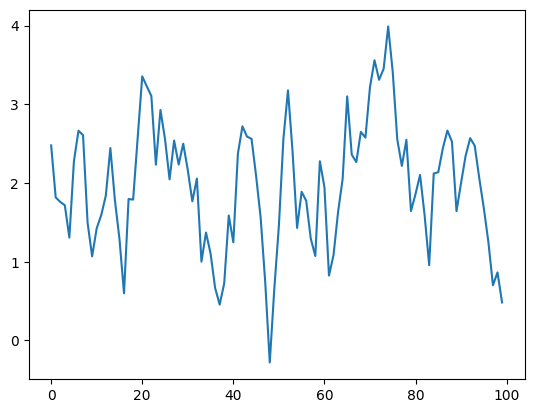

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
import numpy as np
from numpy.random import normal
from math import pi
import pandas as pd

def cycle(N, nof_cycles = 1):
  return np.cos(2*pi*np.arange(0,N)*nof_cycles/N)

def simAR1(N, phi, sigma, const=0, burn=100):
    y = np.zeros((N + burn))
    for t in range(N + burn - 1):
        y[t + 1] = const + phi * y[t] + normal(scale=sigma, size=1)[0]
    return y[burn:]

#np.random.seed(0)   # set seed

N = 1*10**2

omega = 1
phi_true = 0.77
sigma_true = 0.5

y = simAR1(N, phi = phi_true, sigma = sigma_true, const = 0.5)
#y1 = omega*cycle(N, nof_cycles = 2) + simAR1(N, phi = 0.7, sigma = 0.6)
#y4 = omega*cycle(N, nof_cycles = 2) 

# Plot trajectories:
#---------------------
plt.figure()
pd.Series(y).plot() 
plt.show();

Exponentially Weighted Moving Average

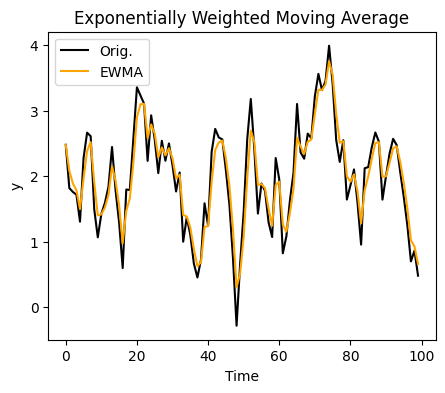

In [2]:
alpha = 0.6    # weight / damping factor

N = len(y)
ewma = np.zeros(N)
ewma[0] = y[0]
for t in range(1,N): 
    ewma[t] = alpha*y[t] + (1-alpha)*ewma[t-1]

# Plot:
#-------
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(range(N), y, color='black', label='Orig.')
ax.plot(range(N), ewma, color='orange', label='EWMA')
ax.set_xlabel('Time')
ax.set_ylabel('y')
ax.set_title('Exponentially Weighted Moving Average')
ax.legend(loc='upper left');

In [3]:
import yfinance as yf

symbols = ['MSFT', 'GOOGL', 'AMZN', 'TSLA']

for symbol in symbols:
    stock = yf.Ticker(symbol)
    info = stock.info
    print(f"Symbol: {symbol}")
    print(f"Name: {info.get('shortName', 'N/A')}")
    print(f"Market: {info.get('market', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print("-" * 30)

Symbol: MSFT
Name: Microsoft Corporation
Market: N/A
Sector: Technology
------------------------------
Symbol: GOOGL
Name: Alphabet Inc.
Market: N/A
Sector: Communication Services
------------------------------
Symbol: AMZN
Name: Amazon.com, Inc.
Market: N/A
Sector: Consumer Cyclical
------------------------------
Symbol: TSLA
Name: Tesla, Inc.
Market: N/A
Sector: Consumer Cyclical
------------------------------


In [4]:
import yfinance as yf
from tabulate import tabulate

symbol = 'AMZN'
start_date = '2020-01-01'
end_date = '2024-11-30'

stock = yf.Ticker(symbol)
historical_data = stock.history(start=start_date, end=end_date)

print(historical_data.shape)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} from {start_date} to {end_date}")

formatted_data = pd.concat([historical_data.head(), historical_data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))

print("\nShowing only the first and last 5 rows of data:")
print(tabulate(formatted_data, headers='keys', tablefmt='grid'))

(1237, 7)
Historical Data for AMZN from 2020-01-01 to 2024-11-30
+---------------------------+---------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |    Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+---------+----------+----------+----------+-------------+-------------+----------------|
| 2020-01-02 00:00:00-05:00 |  93.75  |  94.9005 |  93.2075 |  94.9005 | 8.058e+07   |           0 |              0 |
| 2020-01-03 00:00:00-05:00 |  93.225 |  94.31   |  93.225  |  93.7485 | 7.5288e+07  |           0 |              0 |
| 2020-01-06 00:00:00-05:00 |  93     |  95.1845 |  93      |  95.144  | 8.1236e+07  |           0 |              0 |
| 2020-01-07 00:00:00-05:00 |  95.225 |  95.6945 |  94.602  |  95.343  | 8.0898e+07  |           0 |              0 |
| 2020-01-08 00:00:00-05:00 |  94.902 |  95.55   |  94.322  |  94.5985 | 7.016e+07   |           0 |         

In [5]:
#y_df = yf.download('TSLA')
stock = yf.Ticker("TSLA")
y_df = stock.history(start=start_date, end=end_date)

(1237, 7)


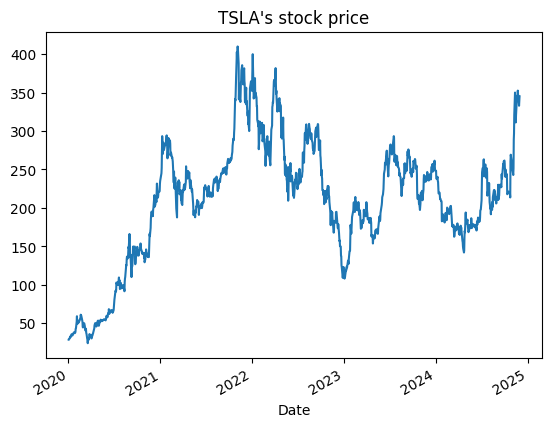

In [6]:
print(y_df.shape)
#ticker = yf.Ticker('TSLA')               # alternative to yf.download()
#tsla_df = ticker.history(period="max")
y_df['Close'].plot(title="TSLA's stock price");

In [7]:

def DLM(y, sig2 = 1.0, tau2 = 0.5, m0 = 0, C0 = 10, back = True):
    """
    Kalman filter and Kalman Smoother - first order dynamic linear model aka 'Local Level Model'
    """
    n  = len(y)
    m0, l = 0, 0
    m, C  = m0, C0
    mf, Cf = np.zeros(n), np.zeros(n) 
    print("Running forward filtering..")

    # Forward filter (Kalman filter)
    #--------------------------------
    for t in range(n):
      R = C + tau2               # state variance
      Q = R + sig2                        # observation variance
      l += norm.logpdf(y[t], loc = m, scale = np.sqrt(Q))   # predictive distr. y_{t} | (y^{t-1}, \theta)
      A = R/Q                             # Kalman Gain
      m = (1-A)*m + A*y[t]          # filtered estimate of the state, see a_{t|t} in Durbin/Koopman, p.13, 2.15
      C = A*sig2
      mf[t] = m           # m_t  ; Forward-filtered mean
      Cf[t] = C           # C_t  ; Forward-filtered variance

    if back:
        print("Running backward smoothing..")
        mb, Cb = np.zeros(n), np.zeros(n)
        
        mb[n-1] = mf[n-1]     # last iteration from Kalman filter
        Cb[n-1] = Cf[n-1]

        # Backward sampler (Kalman smoother)
        #------------------------------------
        for t in range(n-2, -1, -1):
            B = Cf[t]/(Cf[t]+tau2)                # B_t
            mb[t] = (1-B)*mf[t] + B*mb[t+1]       # first two moments of the smoothed state distr.; Smoothed mean
            Cb[t] = (1-B)*Cf[t] + B*B*Cb[t+1]     # Smoothed variance     
        return dict(l=l,mf=mf,Cf=Cf,mb_sm=mb,Cb_sm=Cb)
    else:
        return dict(l=l,mf=mf,Cf=Cf)


In [8]:
dlm  = DLM(y)

Running forward filtering..
Running backward smoothing..


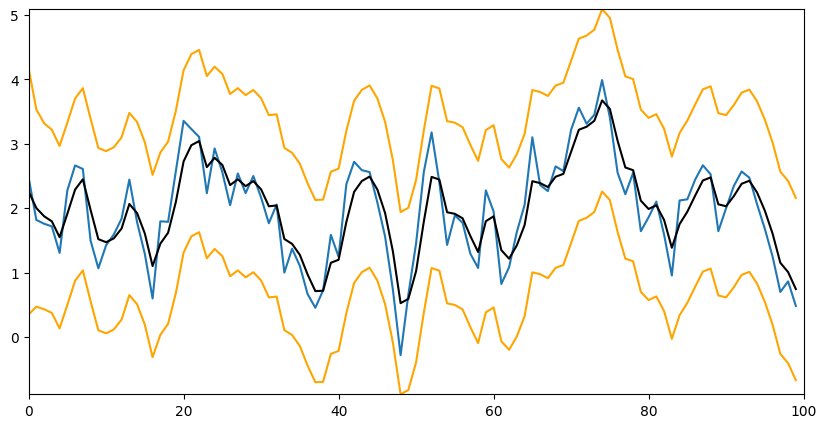

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

N = len(y)

# Plot raw data
#axes.scatter(range(0, N), y)
axes.plot(range(0, N), y)
axes.set_xlim([0, N])
axes.margins(0)

# Plot predictions mean and confidence bounds based on predictive distr.
axes.plot(range(0, N), dlm['mf'], c='black')
_2std = 2*np.sqrt(dlm['Cf'])
axes.plot(range(0, N), dlm['mf'] - _2std, c='orange', ls='-')
axes.plot(range(0, N), dlm['mf'] + _2std, c='orange', ls='-');

In [10]:
def FFBS(y,sig2 = 1.0, tau2 = 0.5, m0 = 0, C0 = 10):
    """
    Forward filtering Backward sampling for Local level model
    y: signal; observations
    sig2: observation variance
    tau2: state variance
    m0, C0: mean and variance prior hyperparameter of states
    """
    n = len(y)
    m, B = np.zeros(n), np.zeros(n-1)
    H, x = np.zeros(n-1), np.zeros(n)

    # Forward filtering:
    #-------------------
    for t in range(n):
        if t==0: 
            a = m0
            R = C0 + tau2
        else:
            a      = m[t-1]
            R      = C + tau2
            B[t-1] = C/R
            H[t-1] = C*tau2/R
        
        A = R/(R+sig2)
        m[t] = (1-A)*a + A*y[t]
        C = A*sig2

    # Backward sampling ('smoothing'):
    #----------------------------------
    x[n-1] = norm.rvs(loc = m[n-1], scale = np.sqrt(C))
    if n > 1:
      for t in range(n-2, -1, -1):
         x[t] = (1-B[t])*m[t] + B[t]*x[t+1] + np.sqrt(H[t])*norm.rvs(size=1)[0]     # Backward sampling!

    return dict(xb=x)

In [11]:
fb = FFBS(y, sig2 = 1.0, tau2 = 0.5, m0 = 0., C0 = 10)

## Gibbs sampling with FFBS

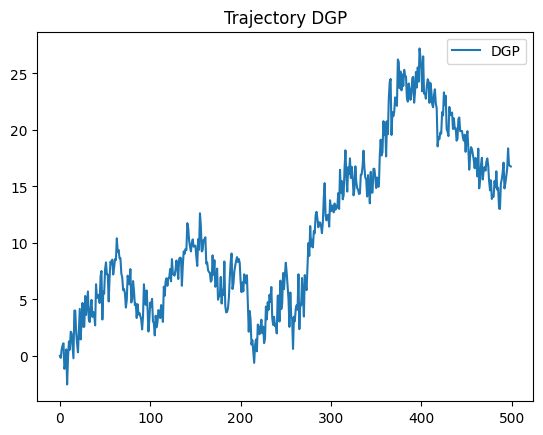

In [12]:
# Simulating 1st order DLM
# -------------------------
tau2 = 0.5    # ground truth parameter values
sig2 = 1.0
N    = 500
x0   = 0.0
tau  = np.sqrt(tau2)
sig  = np.sqrt(sig2)
w    = np.random.normal(0,tau,N)
v    = np.random.normal(0,sig,N)
x    = np.zeros(N)
y    = np.zeros(N)

x[1] = x0 + w[1]
y[1] = x[1] + v[1]
for t in range(1,N):
  x[t] = x[t-1] + w[t]   # state eqn., Local level model
  y[t] = x[t] + v[t]     # obs. eq.

pd.DataFrame(y, columns=['DGP']).plot(title="Trajectory DGP");

In [13]:
# Draw from Posterior pred. of y_n+1
#------------------------------------
def rpost_pred_y(x_T, sigma2, tau2):
   x_Tp1 = np.random.normal(loc = x_T, scale = np.sqrt(tau2), size = 1)   # draw from state equation
   y_Tp1 = np.random.normal(loc = x_Tp1, scale = np.sqrt(sigma2), size = 1)   # draw from observation equation
   return y_Tp1 

Use yahoo data:

In [14]:
y = y_df['Close'].values #.reshape(-1,1)

In [15]:
from tqdm.auto import tqdm

# MCMC scheme (Gibbs sampling):
#-------------------------------
M0 = 1000
M  = 2000
niter = M0+M
nu0 = 5
s02 = 1
n0  = 5
t02 = 0.5
N = len(y)

# Prior information
m0 = 0.0
C0 = 10
sig2d = sig2     # ground truth parameter
tau2d = tau2
states_draws = np.zeros((niter,N))
sig2_draws = np.zeros((niter,1))
tau2_draws = np.zeros((niter,1))
ypred_draws = np.zeros((niter,1))

# Run Gibbs cycle:
#------------------
for iter in tqdm(range(niter), desc="MCMC cycle"):

    xd = FFBS(y,sig2d,tau2d,m0,C0)['xb']    # forward filtering backward sampling
    par1 = (nu0+N)/2
    par2 = (nu0*s02 + np.sum((y-xd)**2))/2

    sig2d = 1/gamma.rvs(a = par1, scale = 1/par2)              # draw from full cond.

    par1 = (n0 + N -1)/2
    par2 = (n0*t02+ np.sum((xd[1:]-xd[:-1])**2))/2
    tau2d = 1/gamma.rvs(a = par1, scale = 1/par2)                    # Gibbs draw
    
    # Draw from posterior predictive of y_T+1 : 
    y_future_p1 = rpost_pred_y(x_T = xd[N-1], sigma2 = sig2d, tau2 = tau2d)
    
    states_draws[iter,:] = xd
    ypred_draws[iter] = y_future_p1[0]
    sig2_draws[iter] = sig2d
    tau2_draws[iter] = tau2d

states_draws = states_draws[M0:,:]  # discard burn-in
sig2_draws = sig2_draws[M0:,:]  
tau2_draws = tau2_draws[M0:,:] 
ypred_draws = ypred_draws[M0:,:]

/Users/mn9lu5b/Library/CloudStorage/OneDrive-Allianz/Github_priv/ts_sandbox/ts_sandbox/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
MCMC cycle: 100%|██████████| 3000/3000 [00:49<00:00, 60.17it/s]


In [16]:
sig2mode = np.mean(sig2_draws)
tau2mode = np.mean(tau2_draws)
ypred_mode = np.mean(ypred_draws)

# Re-apply filtering based on Bayes est.
dlm1  = DLM(y, sig2mode, tau2mode,m0,C0,True) 

qx = np.quantile(states_draws, q = [.025,.5,.975], axis = 1)
qy_pred = np.quantile(ypred_draws.squeeze(), q = [.025,.5,.975], axis = -1)

Running forward filtering..
Running backward smoothing..


In [17]:
# Bayes estimate vs. true parameter value:
print(f'Estimate: {np.round(sig2mode,4)} True: {np.round(sig2d,4)}')

Estimate: 1.8614 True: 1.4774


In [18]:
# Bayes estimate vs. true parameter value:
print(f'Estimate: {np.round(tau2mode,4)} True: {np.round(tau2d,4)}')

Estimate: 70.3523 True: 71.3886


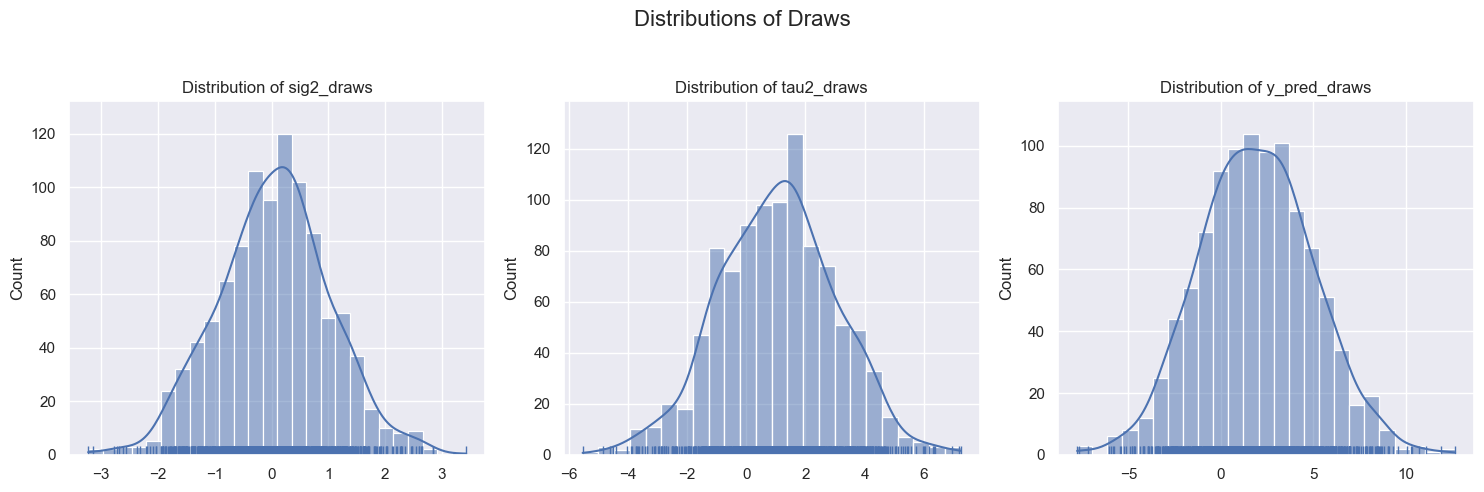

In [24]:
import seaborn as sns

# Sample data
sig2_draws = np.random.normal(0, 1, 1000)
tau2_draws = np.random.normal(1, 2, 1000)
ypred_draws = np.random.normal(2, 3, 1000)

# Set theme
sns.set_theme()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each distribution with rug plots
sns.histplot(sig2_draws, ax=axes[0], kde=True, legend=False)
sns.rugplot(sig2_draws, ax=axes[0])
axes[0].set_title("Distribution of sig2_draws")

sns.histplot(tau2_draws, ax=axes[1], kde=True, legend=False)
sns.rugplot(tau2_draws, ax=axes[1])
axes[1].set_title("Distribution of tau2_draws")

sns.histplot(ypred_draws, ax=axes[2], kde=True, legend=False)
sns.rugplot(ypred_draws, ax=axes[2])
axes[2].set_title("Distribution of y_pred_draws")

# Add overall title
fig.suptitle("Distributions of Draws", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [20]:
#dlm1['mf'] = np.append(dlm1['mf'].tolist(), ypred_draws)

In [ ]:
df = y_df['Close'].iloc[0:100,].copy().to_frame()
print(df.shape)

In [163]:
df = y_df['Close'].copy().to_frame()
df["filter mean"] = dlm1['mf']
df["filter var"] = dlm1['Cf']
df["smooth mean"] = dlm1['mb_sm']
df["smooth var"] = dlm1['Cb_sm']

i = 100

df = df.iloc[0:i,]
print(df.shape)

(100, 5)


Plot filtered/smoothed estimates against ground truth

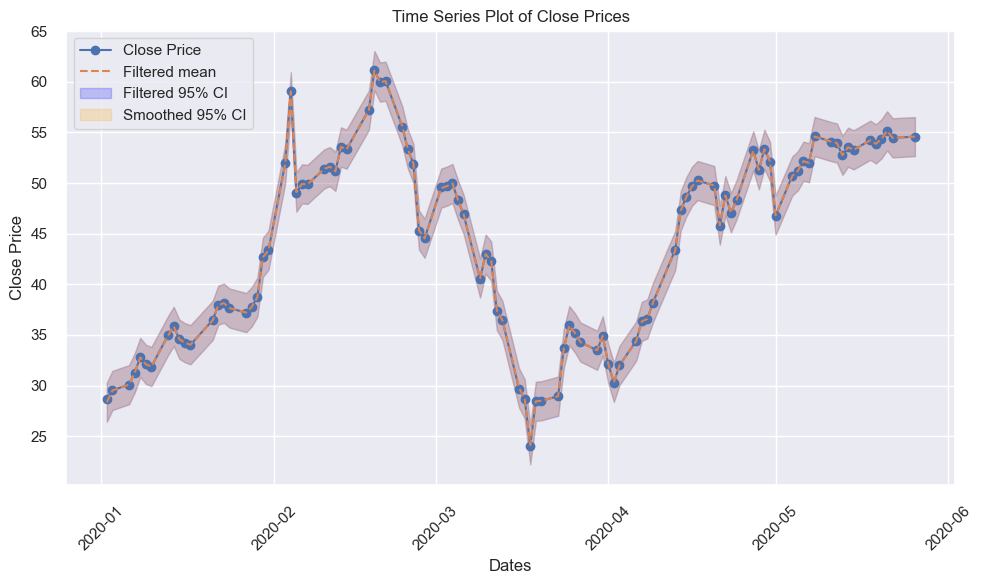

In [ ]:
df['Date'] = pd.to_datetime(df.index)
df.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Close Price', marker='o')      

# Plot predictions mean and confidence bounds based on predictive distr.
plt.plot(df.index, df['filter mean'], label='Filtered mean', ls='--')

std_filtered = np.sqrt(df["filter var"])
std_smoothed = np.sqrt(df["smooth var"])

plt.fill_between(df.index, df['filter mean'] - 2*std_filtered, df['filter mean'] + 2*std_filtered, color='blue', alpha=0.2, label='Filtered 95% CI')
plt.fill_between(df.index, df["smooth mean"] - 2*std_smoothed, df["smooth mean"] + 2*std_smoothed, color='orange', alpha=0.2, label='Smoothed 95% CI')

plt.title('Time Series Plot of Close Prices')
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.grid(True)

# Add tick marks
plt.tick_params(axis='x', which='major', length=10, width=2, labelrotation=45)
plt.tick_params(axis='y', which='major', length=10, width=2)
#plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show();